In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from scipy.optimize import linear_sum_assignment

# load data
lp = '/data2/users/kperks/'
sp = 'ecog_center_out/'
input_file = 'new_data_lfp_mocap.npy'

data = np.load(lp+input_file, allow_pickle=True)
data = data.item()
ecog = data['lfp']
pose = data['mocap']
recording_day = data['events']
times = data['time']

labels = ecog[:,-1,0]
assert (labels == pose[:,-1,0]).all()
n_targets = len(np.unique(labels))

# load model predictions
rootpth = './xdc_runs/'
dat_type = 'train' # 'train', test'
dataset = 'center_out'
sbjs_all = ['BEIG0414c']
subfolders_d = {'center_out': ['center_out_sup_run11']}
datasets = [dataset]

for i, dst in enumerate(datasets):
    subfolders = subfolders_d[dst]
    for i, fold in enumerate(subfolders):
        for j, sbj in enumerate(sbjs_all):
            fID = rootpth + fold + '/' +sbj + '_preds' + '.npy'
            if os.path.exists(fID):
                print(fID)
                preds_data = np.load(fID,allow_pickle=True).item()
            else:
                preds_data = None
            print(preds_data.keys())

train_inds = preds_data['train_split']
test_inds = preds_data['test_split']
train_true = preds_data['true_train']
train_pred = preds_data['pred_train']
test_true = preds_data['true_test']
test_pred = preds_data['pred_test']
print(len(train_inds), train_true[0].shape, test_true[0].shape)

assert train_true[0].shape[0] == test_true[0].shape[0]
n_modalities = train_true[0].shape[0]
assert len(train_inds) == len(test_inds) == len(train_true) == len(test_true)
n_folds = len(train_inds)
print(n_modalities, 'modalities,', n_folds, 'folds')

./xdc_runs/center_out_sup_run11/BEIG0414c_preds.npy
dict_keys(['train_split', 'test_split', 'true_train', 'pred_train', 'true_test', 'pred_test'])
10 (2, 410) (2, 46)
2 modalities, 10 folds


In [12]:
# get matrix of true vs. predicted labels
w_allfolds = np.zeros((n_folds, n_targets, n_targets)) # fold x pred x true

j = 1 # modality [neural, pose]
for i in range(n_folds):
    train_true_curr = train_true[i][j]
    train_pred_curr = train_pred[i][j]
    test_true_curr = test_true[i][j]
    test_pred_curr = test_pred[i][j]
    
    ind, D = None, None
    if dat_type == 'train':       
        y_true = np.asarray(train_true_curr)
        y_pred = np.asarray(train_pred_curr) 
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
    elif dat_type == 'test':
        # get train mapping 
        y_true = np.asarray(train_true_curr)
        y_pred = np.asarray(train_pred_curr)
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
        assert y_pred.size == y_true.size
        if not D:
            D = max(y_pred.max(), y_true.max()) + 1
            D = int(D)
        w = np.zeros((D, D), dtype=np.int64)
        for t in range(y_pred.size):
            w[y_pred[t], y_true[t]] += 1
        if not ind:
            ind = linear_sum_assignment(w.max() - w)

        # use train mapping to get test accuracy
        y_true = np.asarray(test_true_curr)
        y_pred = np.asarray(test_pred_curr)
        y_true = y_true.astype(np.int64)
        y_pred = y_pred.astype(np.int64)
    
    assert y_pred.size == y_true.size
    if not D:
        D = max(y_pred.max(), y_true.max()) + 1
        D = int(D)
    w = np.zeros((D, D), dtype=np.int64)
    for t in range(y_pred.size):
        w[y_pred[t], y_true[t]] += 1
    if not ind:
        ind = linear_sum_assignment(w.max() - w)
    print('pred:',ind[0],'true:',ind[1])

    acc = w[ind[0], ind[1]].sum()* 1.0 / y_pred.size
    w_allfolds[i] = w/w.max() # proportion per fold
    # print(acc)
    # print(w)
    # print(ind)
    # print(w[ind[0], ind[1]])

w_avg = w_allfolds.mean(0) # average proportion over folds
print(w_avg)

pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
pred: [0 1 2 3 4 5 6 7] true: [0 1 2 3 4 5 6 7]
[[0.93688358 0.         0.         0.         0.03750245 0.
  0.         0.        ]
 [0.         0.74616557 0.         0.03961708 0.         0.12319032
  0.         0.06943023]
 [0.         0.         0.86023209 0.         0.         0.
  0.14620107 0.        ]
 [0.         0.1153237  0.00192308 0.9586168  0.         0.15219503
  0.         0.00792157]
 [0.07935189 0.         0.         0.         0.97869382 0.
  0.         0.        ]
 [0.         0.0299735  0.         0.         0.         0.25750691
  0.       

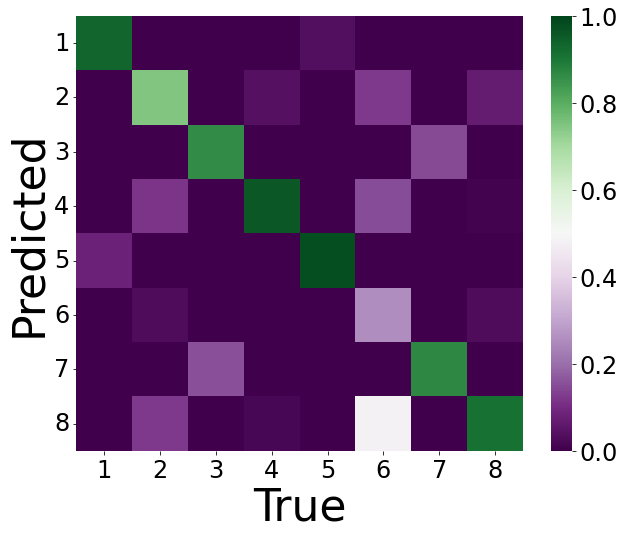

In [13]:
# plot true vs. predicted labels
import seaborn as sns
sz = 24

plt.figure(figsize=(10,8))
ax = sns.heatmap(w_avg, vmin=0, vmax=1, cmap='PRGn')
plt.xlabel('True', fontsize=44)
plt.ylabel('Predicted', fontsize=44)
plt.xticks(np.arange(n_targets)+0.5, range(1,9), fontsize=sz)
plt.yticks(np.arange(n_targets)+0.5, range(1,9), fontsize=sz, rotation=0);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=sz)
# plt.savefig('xdc_runs/figs/'+subfolders[0][11:]+'_'+dat_type+'_pred_heatmap.png')